In [1]:
from sar.utils.factory import sarimage
from sar.render.palette import getColorMap
from sar.transform.sarimage2sarxspec import sarimage2sarxspec
import numpy as np
from numpy.fft import fft2, ifft2, fftshift
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline
dpi = float(matplotlib.rcParams['savefig.dpi'])

# SAR Cross Spectrum

## Imagette test

In [2]:
# Instantiate reader object
path = '/home/cercache/project/mpc-sentinel1/data/esa/sentinel-1a/L1/WV/S1A_WV_SLC__1S/2015/199/'\
    'S1A_WV_SLC__1SSV_20150718T013216_20150718T015501_006858_0093FB_C717.SAFE/measurement/'\
    's1a-wv2-slc-vv-20150718t014147-20150718t014150-006858-0093fb-040.tiff'
sarim = sarimage(path)
# Get complex signal
image = sarim.get_data('complex')
ground_spacing = sarim.ground_spacing()
prf = sarim.get_info('pulse_repetition_frequency')
print 'Imagette shape : {}'.format(image.shape)
print 'Imagette azimuth / range ground spacing : {:.2f} m / {:.2f} m'.format(*ground_spacing)

Imagette shape : (4785, 4396)
Imagette azimuth / range ground spacing : 4.15 m / 4.59 m


## SAR Cross Spectrum : step by step (for a piece of imagette)

### Periodogram

In [3]:
# Get a piece of imagette, apply a window then FFT
azi_periodo_size, ran_periodo_size = 1024, 1024
azi_start, ran_start = 500, 500
piece = image[azi_start:azi_start + azi_periodo_size, ran_start:ran_start + ran_periodo_size]
intensity = np.float64(abs(piece) ** 2).mean()
aziwindow = np.hanning(azi_periodo_size + 2)[1:-1]
ranwindow = np.hanning(ran_periodo_size + 2)[1:-1]
window = np.sqrt(np.outer(aziwindow, ranwindow) / intensity)
periodo = fftshift(fft2(piece * window))

### Show

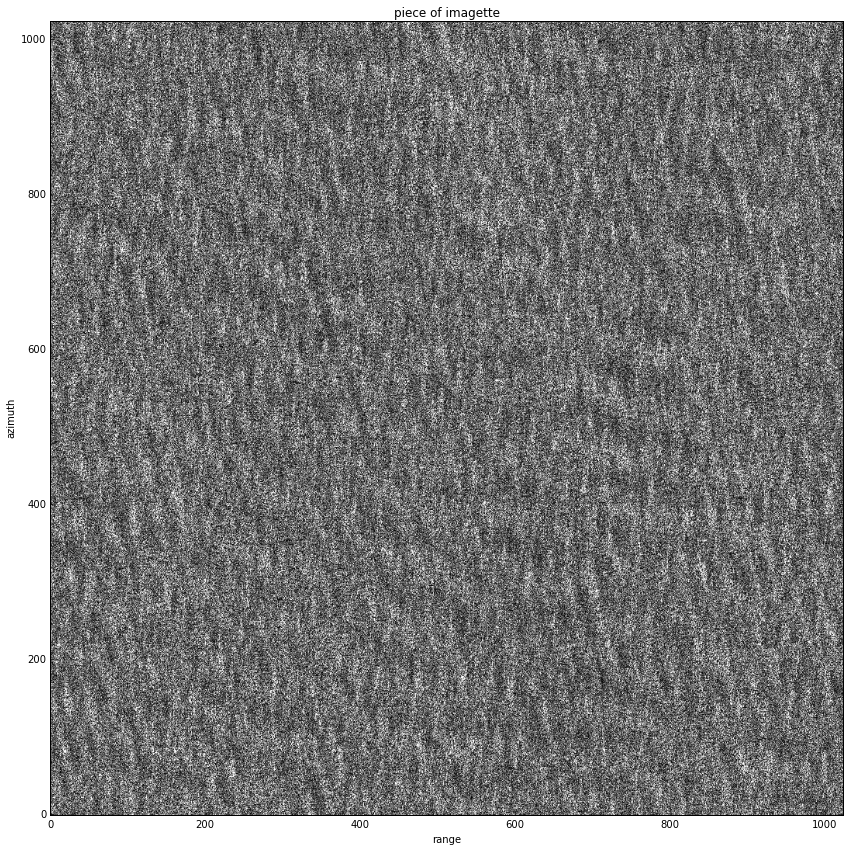

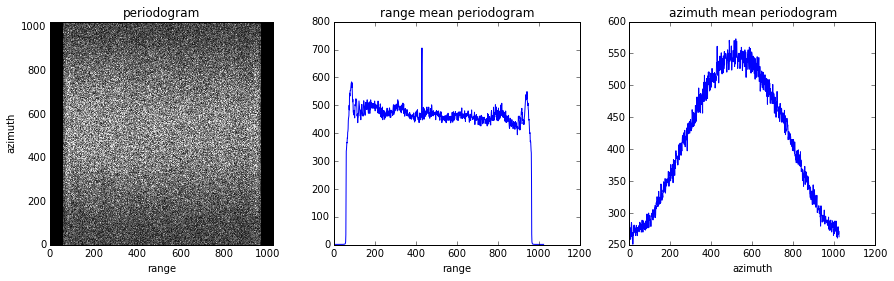

In [4]:
# Piece of imagette
plt.figure(figsize=(ran_periodo_size/dpi, azi_periodo_size/dpi))
vmin, vmax = np.percentile(abs(piece), [1, 99])
plt.imshow(abs(piece), cmap=plt.cm.Greys_r, origin='lower', vmin=vmin, vmax=vmax)
plt.title('piece of imagette')
plt.xlabel('range')
plt.ylabel('azimuth')
# Periodogram
plt.figure(figsize=(15, 4))
vmin, vmax = np.percentile(abs(periodo), [1, 99])
plt.subplot(1, 3, 1)
plt.imshow(abs(periodo), cmap=plt.cm.Greys_r, origin='lower', vmin=vmin, vmax=vmax)
plt.title('periodogram')
plt.xlabel('range')
plt.ylabel('azimuth')
plt.subplot(1, 3, 2)
plt.plot(abs(periodo).mean(axis=0))
plt.title('range mean periodogram')
plt.xlabel('range')
plt.subplot(1, 3, 3)
plt.plot(abs(periodo).mean(axis=1))
plt.title('azimuth mean periodogram')
plt.xlabel('azimuth')

### Doppler spectrum and looks extraction

In [5]:
# Shift periodogram in azimuth (doppler spectrum) according to doppler centroid
extent = [azi_start, ran_start, azi_start + azi_periodo_size, ran_start + ran_periodo_size]
doppler_centroid = sarim.get_data('doppler_centroid', extent=extent, midrange=True, midazimuth=True)[0, 0]
doppler_shift = np.round(doppler_centroid / prf * azi_periodo_size).astype('int32')
periodo_shift = periodo.copy() # in order to rerun this block independently
periodo_shift = np.roll(periodo_shift, -doppler_shift, axis=0)
# Extract looks
ran_look_width = 0.78 # in %
azi_look_width = 0.25 # in %
nlooks = 3
look_sep = 0.27 # in %, separation between the start of two consecutive looks
azi_look_size = np.floor(azi_periodo_size * azi_look_width + 0.5).astype('int32')
ran_look_size = np.floor(ran_periodo_size * ran_look_width + 0.5).astype('int32')
azi_look_pos = np.floor((np.linspace(1 - nlooks, nlooks - 1, num=nlooks) * look_sep + 1 - azi_look_width) * \
                        0.5 * azi_periodo_size).astype('int32')
ran_look_pos = np.floor(0.5 * (ran_periodo_size - ran_look_size) + 0.5).astype('int32')
azi_power = np.ceil(np.log(azi_look_width) / np.log(2) + 1).astype('int32') - 1
ran_power = np.ceil(np.log(ran_look_width) / np.log(2) + 1).astype('int32') - 1
azi_spec_size = np.floor(2. ** azi_power * azi_periodo_size + 0.5).astype('int32')
ran_spec_size = np.floor(2. ** ran_power * ran_periodo_size + 0.5).astype('int32')
look = np.zeros((azi_spec_size, ran_spec_size), dtype='complex64')
looks = np.zeros((azi_spec_size, ran_spec_size, nlooks), dtype='complex64')
spatial_looks = np.zeros((azi_spec_size, ran_spec_size, nlooks), dtype='float32')
for n, alpos in enumerate(azi_look_pos):
    look[0:azi_look_size, 0:ran_look_size] = periodo[alpos:alpos + azi_look_size, \
                                                     ran_look_pos:ran_look_pos + ran_look_size]
    spatial_look = abs(ifft2(look)) ** 2
    looks[:, :, n] = fft2(spatial_look)
    spatial_looks[:, :, n] = spatial_look # for display

### Show

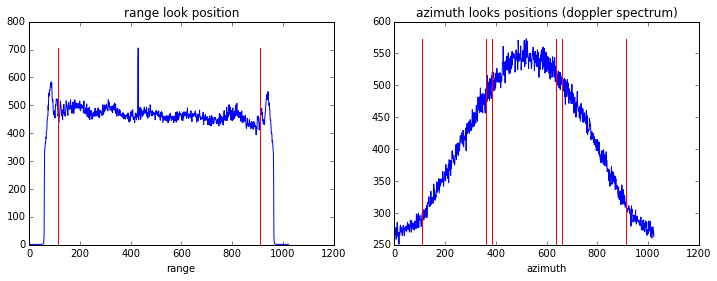

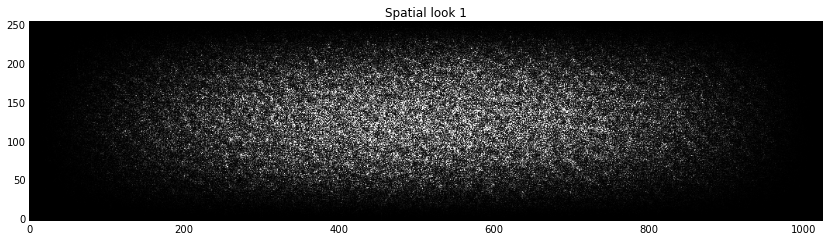

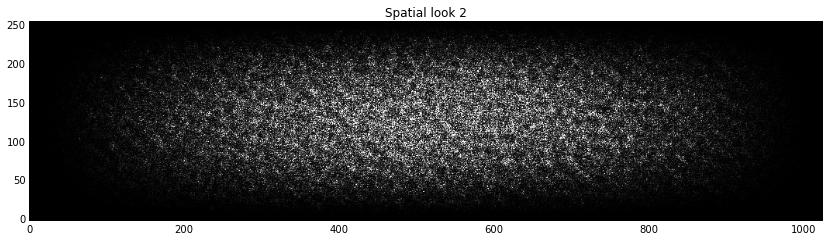

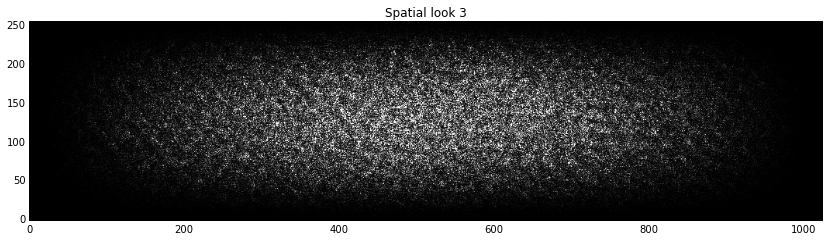

In [6]:
# Looks positions
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(abs(periodo_shift).mean(axis=0))
plt.title('range look position')
plt.xlabel('range')
min = abs(periodo_shift).mean(axis=0).min()
max = abs(periodo_shift).mean(axis=0).max()
plt.plot([ran_look_pos] * 2, [min, max], 'r')
plt.plot([ran_look_pos + ran_look_size - 1] * 2, [min, max], 'r')
plt.subplot(1, 2, 2)
plt.plot(abs(periodo).mean(axis=1))
plt.title('azimuth looks positions (doppler spectrum)')
plt.xlabel('azimuth')
min = abs(periodo_shift).mean(axis=1).min()
max = abs(periodo_shift).mean(axis=1).max()
for n in range(nlooks):
    plt.plot([azi_look_pos[n]] * 2, [min, max], 'r')
    plt.plot([azi_look_pos[n] + azi_look_size - 1] * 2, [min, max], 'r')
# Spatial looks
for n in range(nlooks):
    plt.figure(figsize=(ran_spec_size / dpi, azi_spec_size / dpi))
    vmin, vmax = np.percentile(spatial_looks[:, :, n], [1, 99])
    plt.imshow(spatial_looks[:, :, n], cmap=plt.cm.Greys_r, origin='lower', vmin=vmin, vmax=vmax)
    plt.title('Spatial look {}'.format(n + 1))

### Cross spectrum

In [7]:
# Multiply looks
co_cross_spec = np.zeros((azi_spec_size, ran_spec_size, nlooks), dtype='complex64')
for n in range(nlooks):
    for m in range(n + 1):
        co_cross_spec[:, :, n - m] += looks[:, :, n] * np.conj(looks[:, :, m])
# Normalise by number of looks
for n in range(nlooks):
    co_cross_spec[:, :, n] /= nlooks - n
# Shift
for n in range(nlooks):
    co_cross_spec[:, :, n] = fftshift(co_cross_spec[:, :, n])

### Show

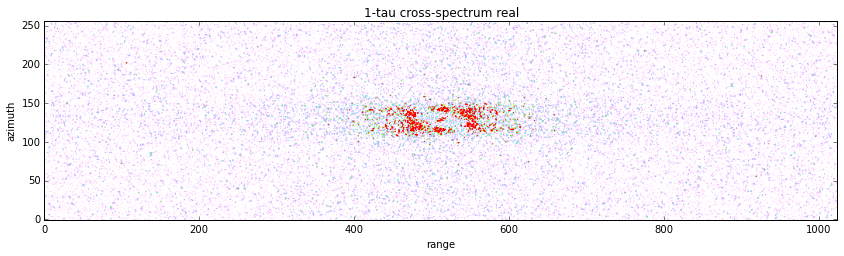

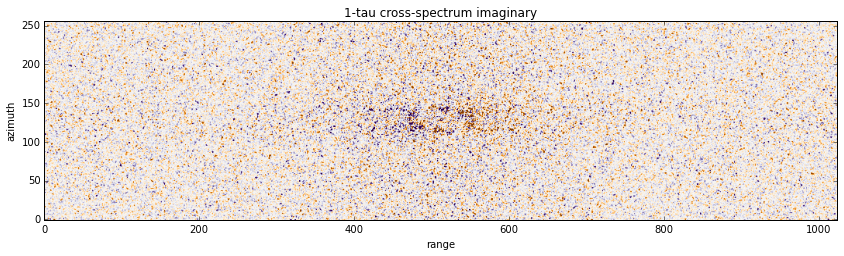

In [8]:
# 1-tau real
plt.figure(figsize=(ran_spec_size / dpi, azi_spec_size / dpi))
vmax = np.percentile(co_cross_spec[:, :, 1].real, 99.5)
plt.imshow(co_cross_spec[:, :, 1].real, cmap=getColorMap('wind.pal'), origin='lower', vmin=0, vmax=vmax)
plt.title('1-tau cross-spectrum real')
plt.xlabel('range')
plt.ylabel('azimuth')
# 1-tau imaginary
plt.figure(figsize=(ran_spec_size / dpi, azi_spec_size / dpi))
vmax = np.percentile(abs(co_cross_spec[:, :, 1].imag), 99.5)
plt.imshow(co_cross_spec[:, :, 1].imag, cmap=plt.cm.PuOr, origin='lower', vmin=-vmax, vmax=vmax)
plt.title('1-tau cross-spectrum imaginary')
plt.xlabel('range')
plt.ylabel('azimuth')

## Play with processing parameters and visualize (high level functions)

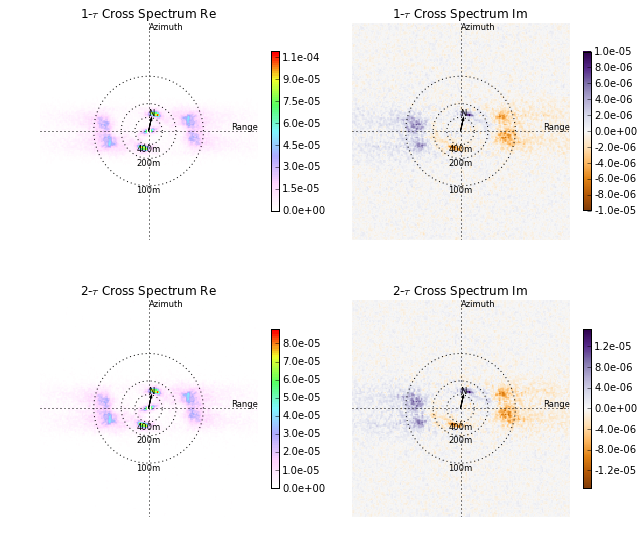

In [9]:
# Same processing parameters as in the step by step section
# But many periodograms are computed inside imagette (decreases the noise)
# And the display takes care of the range/azimuth wavenumbers
extent = sarim.extent_max()
sarxspec = sarimage2sarxspec(sarim, extent, azi_periodo_size=1024, ran_periodo_size=None, azi_spec_size=None,
                             ran_spec_size=None, azi_look_width=0.25, nlooks=3, look_sep=0.27, ran_look_width=0.78)
fig = sarxspec.display_data()

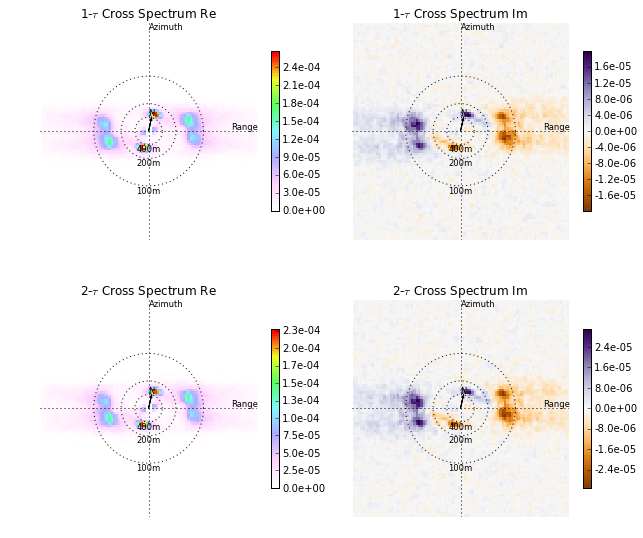

In [10]:
# Decreases periodogram size (decreases noise but also spectral resolution)
sarxspec2 = sarimage2sarxspec(sarim, extent, azi_periodo_size=512, ran_periodo_size=None, azi_spec_size=None,
                             ran_spec_size=None, azi_look_width=0.25, nlooks=3, look_sep=0.27, ran_look_width=0.78)
fig2 = sarxspec2.display_data()